ТОДО:
    визуализировать деревья
    алгоритм в дереве
    нарисовать прогноз на следующий день
    радиально-базисные функции

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ARDRegression
import random
random.seed(42)

%load_ext autoreload
%autoreload 2

In [9]:
errors = {}
init_data = pd.read_excel("./phc_mo3_and_tripms.xls")
main_features = init_data.drop(columns=['day number', 'Speed','Heart rate','Load','Avg PhC 9days', 'Avg PhC 3days',
'Avg Forecast 3 days','Unnamed: 13','Unnamed: 14','Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 
                        'Unnamed: 19'], axis=0)
main_features.drop(labels=range(11), inplace=True)
print(main_features.shape)
edited_features = main_features.dropna(axis='rows', how="any")
edited_features = main_features.drop(columns=['Forecast'], axis=0)
print(edited_features.shape)
edited_features.head(10)

(204, 6)
(204, 5)


,Physiological Cost (PhC),TRIMP1,TRIMP2,TRIMP3,TRIMP4
11,0.372097,802.127,138.638,1.23169,0
12,0.353656,1450.13,100.318,1341.57,579.98
13,0.354685,732.626,70.6103,2440.17,1695.58
14,0.330189,809.691,13.2364,1778.61,880.455
15,0.371243,769.12,26.4721,1773.54,887.856
16,NaN,1366.48,494.083,1328.01,585.427
17,0.319281,738.895,1.30417,2444.16,1676.64
18,0.347529,670.607,10.3701,1779.52,877.502
19,0.367796,722.044,51.7193,1776.15,889.079
20,NaN,NaN,NaN,NaN,NaN


In [3]:
# sns.jointplot(data=edited_features,x='Physiological Cost (PhC)', y='TRIMP1')
for col in edited_features:
    print("%s:"%col)
    print("Mean: %f"%edited_features[col].mean())
    print("STD: %f\n"%edited_features[col].std())

Physiological Cost (PhC):
Mean: 0.335016
STD: 0.025161

TRIMP1:
Mean: 848.360259
STD: 461.174565

TRIMP2:
Mean: 373.103591
STD: 333.070395

TRIMP3:
Mean: 1888.585938
STD: 776.061225

TRIMP4:
Mean: 978.378106
STD: 497.473287



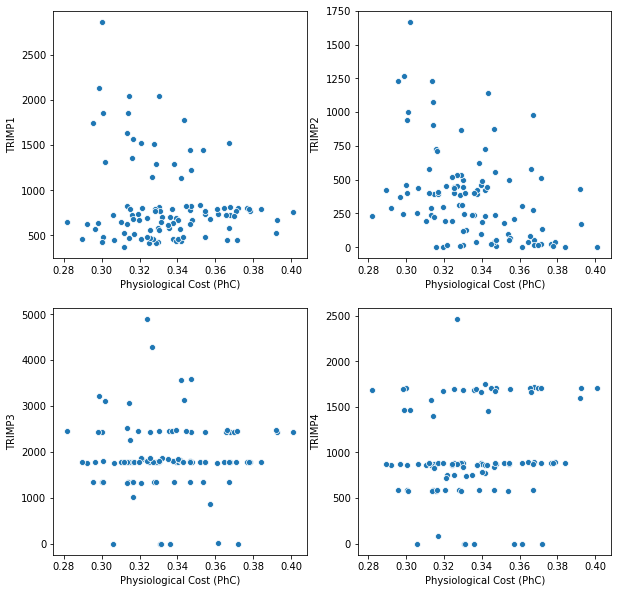

In [4]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
sns.scatterplot(x='Physiological Cost (PhC)', y='TRIMP1', data=edited_features, ax=ax[0,0])
sns.scatterplot(x='Physiological Cost (PhC)', y='TRIMP2', data=edited_features, ax=ax[0,1])
sns.scatterplot(x='Physiological Cost (PhC)', y='TRIMP3', data=edited_features, ax=ax[1,0])
sns.scatterplot(x='Physiological Cost (PhC)', y='TRIMP4', data=edited_features, ax=ax[1,1])

In [4]:
forecast = init_data["Forecast"]
forecast_loss = np.sum(edited_features["Physiological Cost (PhC)"] - forecast)/len(forecast)
errors.update({"forecast error":forecast_loss})
print("среднее значение ошибки Вашего линейного предсказания:", forecast_loss)

среднее значение ошибки Вашего линейного предсказания: 0.05943365069409665


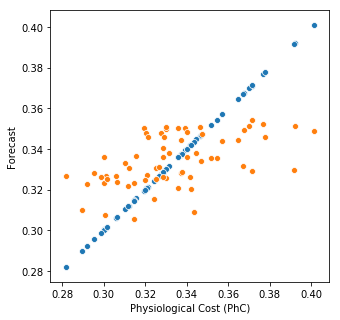

In [4]:
fig, ax = plt.subplots(figsize=(5,5))
forec = main_features[main_features['Forecast']!=0]
sns.scatterplot(data=forec, x='Physiological Cost (PhC)', y='Physiological Cost (PhC)')
sns.scatterplot(data=forec, x='Physiological Cost (PhC)', y='Forecast')
del forec

In [6]:
USE_GPU = False # на моём текущем устройстве не поддерживается новый пайторч

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cpu


In [7]:
from networks.model import train
from networks.Dataset import MyDataset

def test_model(model, train_set, X_test, y_test, batch_size=20, num_epochs=10):
    model.train()
    %time train(model, train_set, batch_size, epochs=num_epochs)

    model.eval()
    y_pred = model.forward(torch.Tensor(np.asarray(X_test, dtype=np.float64))).detach().numpy().squeeze()
    
    sns.scatterplot(train_set.target, train_set.target)
    sns.scatterplot(train_set.target, model.forward(torch.Tensor(np.asarray(X_train, dtype=np.float64))).detach().numpy().squeeze()) 
    sns.scatterplot(y_test, y_pred)
    
    return test_accuracy(y_test, y_pred)

In [8]:
def test_accuracy(y_test, y_pred):
#     loss = 0
#     for i in range(len(y_test)):
#         l = abs(y_pred[i] - y_test.values[i])
#         loss += l
#     loss /= len(y_test)
    loss = np.mean(np.abs(y_pred.squeeze() - y_test.values))
    print("ошибка текущей модели: %.15e" % loss)
    return loss
#     print("относительная ошибка: %.9f"% (loss / forecast_loss))
#     print("разность ошибок: %.9f" % abs(loss - forecast_loss))

# Модель со входом = 4 на базовых данных

In [70]:
model = nn.Sequential(
    nn.BatchNorm1d(4),
    nn.Linear(4,32),
    nn.BatchNorm1d(32),
    nn.LeakyReLU(),
#     nn.Dropout(0.1),
    nn.Linear(32,32),
    nn.BatchNorm1d(32),
    nn.LeakyReLU(),
#     nn.Dropout(0.1),
    nn.Linear(32, 64),
    nn.BatchNorm1d(64),
    nn.LeakyReLU(),
#     nn.Dropout(0.1),
    nn.Linear(64,1)
)

In [71]:
X = edited_features.drop(['Physiological Cost (PhC)'], axis='columns')
y = edited_features['Physiological Cost (PhC)'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)

In [72]:
# train_set = MyDataset(train_data=X, train_target=y)
# num_epochs = 1000
# batch_size = 16
# test_model(model, train_set, X, y, batch_size, num_epochs)

CPU times: user 14 s, sys: 123 ms, total: 14.1 s
Wall time: 2.72 s
ошибка текущей модели: 2.182292959737723e-02


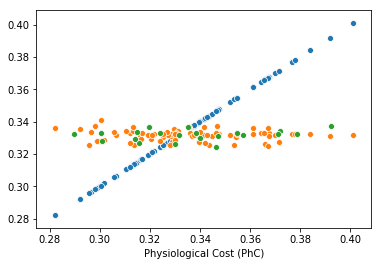

In [81]:
train_set = MyDataset(train_data=X_train, train_target=y_train)
num_epochs = 100
batch_size = 16
errors.update({"default(4) test error":test_model(model, train_set, X_test, y_test, batch_size, num_epochs)})

In [13]:
mask = np.argsort(y.values)
diff = 0
for i in range(mask.shape[0] - 1):
    diff += y.values[mask][i + 1] - y.values[mask][i]
diff /= y.shape[0]
print("%.10e"%diff) 

1.1579321359e-03


Отсюда делаем вывод, что нам необходимо преодолеть хотя бы порог точности порядка 1е-3

Далее попробую посоздавать новых признаков из старых.
Возможно понадобится переделать модель.

# Модель со входом=6.

In [14]:
model = nn.Sequential(
    nn.BatchNorm1d(6),
    nn.Linear(6,32),
    nn.BatchNorm1d(32),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(32,32),
    nn.BatchNorm1d(32),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(32, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(64,1)
)

In [15]:
X_sum = pd.DataFrame()
X_sum["1,2"] = X['TRIMP1'] + X['TRIMP2']
X_sum["1,3"] = X['TRIMP1'] + X['TRIMP3']
X_sum["1,4"] = X['TRIMP1'] + X['TRIMP4']
X_sum["2,3"] = X['TRIMP2'] + X['TRIMP3']
X_sum["2,4"] = X['TRIMP2'] + X['TRIMP4']
X_sum["3,4"] = X['TRIMP3'] + X['TRIMP4']

CPU times: user 14.4 s, sys: 104 ms, total: 14.5 s
Wall time: 2.87 s
ошибка текущей модели: 2.665566685203261e-02


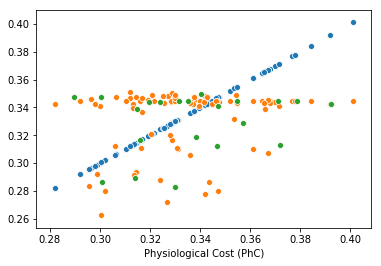

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_sum, y, test_size=0.20, random_state=42, shuffle=True)
train_set = MyDataset(train_data=X_train, train_target=y_train)

errors.update({"sum(6) error":test_model(model, train_set, X_test, y_test, batch_size, num_epochs)})

In [17]:
X_prod = pd.DataFrame()
X_prod["1,2"] = X['TRIMP1'] * X['TRIMP2']
X_prod["1,3"] = X['TRIMP1'] * X['TRIMP3']
X_prod["1,4"] = X['TRIMP1'] * X['TRIMP4']
X_prod["2,3"] = X['TRIMP2'] * X['TRIMP3']
X_prod["2,4"] = X['TRIMP2'] * X['TRIMP4']
X_prod["3,4"] = X['TRIMP3'] * X['TRIMP4']

CPU times: user 14.4 s, sys: 93.9 ms, total: 14.5 s
Wall time: 2.85 s
ошибка текущей модели: 2.261592723088655e-02


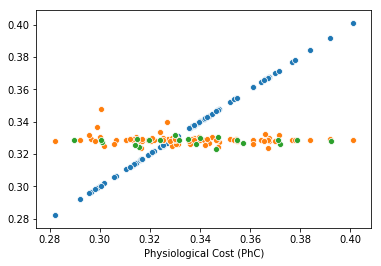

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_prod, y, test_size=0.20, random_state=42, shuffle=True)
train_set = MyDataset(train_data=X_train, train_target=y_train)

errors.update({"product(6) error":test_model(model, train_set, X_test, y_test, batch_size, num_epochs)})

In [19]:
X_avg = pd.DataFrame()
X_avg["1,2"] = (X['TRIMP1'] + X['TRIMP2']) / 2
X_avg["1,3"] = (X['TRIMP1'] + X['TRIMP3']) / 2
X_avg["1,4"] = (X['TRIMP1'] + X['TRIMP4']) / 2
X_avg["2,3"] = (X['TRIMP2'] + X['TRIMP3']) / 2
X_avg["2,4"] = (X['TRIMP2'] + X['TRIMP4']) / 2
X_avg["3,4"] = (X['TRIMP3'] + X['TRIMP4']) / 2

CPU times: user 14.4 s, sys: 131 ms, total: 14.5 s
Wall time: 2.84 s
ошибка текущей модели: 2.147725752657935e-02


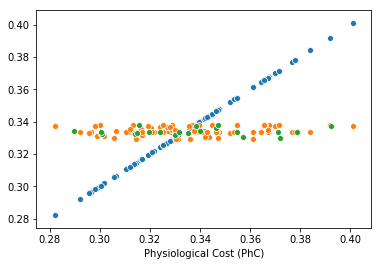

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_avg, y, test_size=0.20, random_state=42, shuffle=True)
train_set = MyDataset(train_data=X_train, train_target=y_train)

errors.update({"average(6) error":test_model(model, train_set, X_test, y_test, batch_size, num_epochs)})

# Модель со входом=2.

In [21]:
model = nn.Sequential(
    nn.BatchNorm1d(2),
    nn.Linear(2,32),
    nn.BatchNorm1d(32),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(32,32),
    nn.BatchNorm1d(32),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(32, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(64,1)
)

In [22]:
X_sum = pd.DataFrame()
X_sum["1,2"] = X['TRIMP1'] + X['TRIMP2']
X_sum["3,4"] = X['TRIMP3'] + X['TRIMP4']

CPU times: user 14.4 s, sys: 97.2 ms, total: 14.5 s
Wall time: 2.82 s
ошибка текущей модели: 2.301563880713108e-02


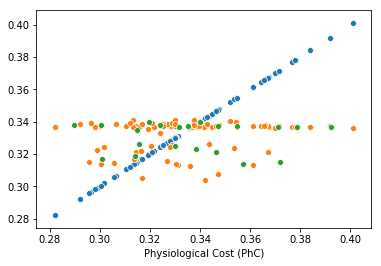

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_sum, y, test_size=0.20, random_state=42, shuffle=True)
train_set = MyDataset(train_data=X_train, train_target=y_train)

errors.update({"sum(2) error":test_model(model, train_set, X_test, y_test, batch_size, num_epochs)})

In [24]:
X_prod = pd.DataFrame()
X_prod["1,2"] = X['TRIMP1'] * X['TRIMP2']
X_prod["3,4"] = X['TRIMP3'] * X['TRIMP4']

CPU times: user 14.4 s, sys: 92.4 ms, total: 14.5 s
Wall time: 2.84 s
ошибка текущей модели: 2.200618174850681e-02


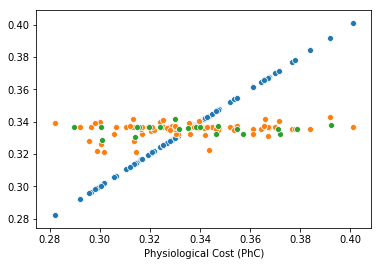

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_prod, y, test_size=0.20, random_state=42, shuffle=True)
train_set = MyDataset(train_data=X_train, train_target=y_train)

errors.update({"product(2) error":test_model(model, train_set, X_test, y_test, batch_size, num_epochs)})

In [26]:
X_avg = pd.DataFrame()
X_avg["1,2"] = (X['TRIMP1'] + X['TRIMP2']) / 2
X_avg["3,4"] = (X['TRIMP3'] + X['TRIMP4']) / 2

CPU times: user 14.4 s, sys: 65.2 ms, total: 14.5 s
Wall time: 2.76 s
ошибка текущей модели: 2.204701264935447e-02


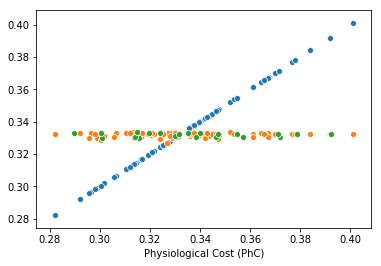

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_avg, y, test_size=0.20, random_state=42, shuffle=True)
train_set = MyDataset(train_data=X_train, train_target=y_train)

errors.update({"average_1(2) error":test_model(model, train_set, X_test, y_test, batch_size, num_epochs)})

In [28]:
X_avg = pd.DataFrame()
X_avg["1,3"] = (X['TRIMP1'] + X['TRIMP3']) / 2
X_avg["2,4"] = (X['TRIMP2'] + X['TRIMP4']) / 2

CPU times: user 14.4 s, sys: 90.2 ms, total: 14.5 s
Wall time: 2.84 s
ошибка текущей модели: 2.310739580072312e-02


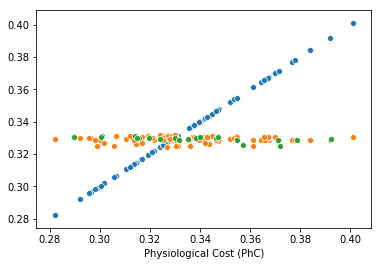

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_avg, y, test_size=0.20, random_state=42, shuffle=True)
train_set = MyDataset(train_data=X_train, train_target=y_train)

errors.update({"average_2(2) error":test_model(model, train_set, X_test, y_test, batch_size, num_epochs)})

In [30]:
X_avg = pd.DataFrame()
X_avg["1,4"] = (X['TRIMP1'] + X['TRIMP4']) / 2
X_avg["3,2"] = (X['TRIMP3'] + X['TRIMP2']) / 2

CPU times: user 14.4 s, sys: 83 ms, total: 14.5 s
Wall time: 2.81 s
ошибка текущей модели: 2.193943194216773e-02


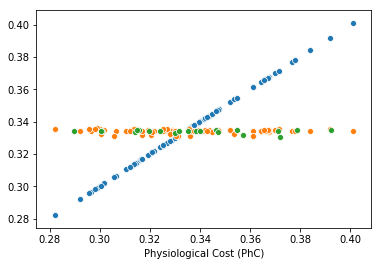

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_avg, y, test_size=0.20, random_state=42, shuffle=True)
train_set = MyDataset(train_data=X_train, train_target=y_train)

errors.update({"average_3(2) error":test_model(model, train_set, X_test, y_test, batch_size, num_epochs)})

In [32]:
# legacy на память
# model.train()
# trained_model = train(model, train_set, batch_size, epochs=num_epochs)

# model.eval()
# y_pred = trained_model.forward(torch.Tensor(np.asarray(X_test, dtype=np.float64))).detach().numpy()

# test_accuracy(y_test, y_pred)

# Модель со входом = 10


In [33]:
model = nn.Sequential(
    nn.BatchNorm1d(10),
    nn.Linear(10,32),
    nn.BatchNorm1d(32),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(32,32),
    nn.BatchNorm1d(32),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(32, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(64,1)
)

In [34]:
X_avg = pd.DataFrame()
X_avg["1,2"] = (X['TRIMP1'] + X['TRIMP2']) / 2
X_avg["1,3"] = (X['TRIMP1'] + X['TRIMP3']) / 2
X_avg["1,4"] = (X['TRIMP1'] + X['TRIMP4']) / 2
X_avg["2,3"] = (X['TRIMP2'] + X['TRIMP3']) / 2
X_avg["2,4"] = (X['TRIMP2'] + X['TRIMP4']) / 2
X_avg["3,4"] = (X['TRIMP3'] + X['TRIMP4']) / 2
X_avg["1,2,3"] = (X['TRIMP1'] + X['TRIMP2'] + X['TRIMP3']) / 3
X_avg["1,2,4"] = (X['TRIMP1'] + X['TRIMP2'] + X['TRIMP4']) / 3
X_avg["2,3,4"] = (X['TRIMP4'] + X['TRIMP2'] + X['TRIMP3']) / 3
X_avg["1,2,3,4"] = (X['TRIMP1'] + X['TRIMP2'] + X['TRIMP3'] + X['TRIMP4']) / 4

CPU times: user 14.5 s, sys: 42.2 ms, total: 14.5 s
Wall time: 2.83 s
ошибка текущей модели: 1.984423215147618e-02


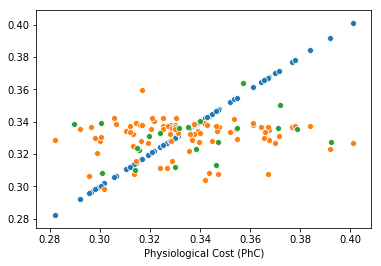

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_avg, y, test_size=0.20, random_state=42, shuffle=True)
train_set = MyDataset(train_data=X_train, train_target=y_train)

errors.update({"average(10) error":test_model(model, train_set, X_test, y_test, batch_size, num_epochs)})

Сделаем модель на слой глубже

In [36]:
model = nn.Sequential(
    nn.BatchNorm1d(10),
    nn.Linear(10,32),
    nn.BatchNorm1d(32),
    nn.ReLU(),
#     nn.Dropout(0.1),
    nn.Linear(32,32),
    nn.BatchNorm1d(32),
    nn.ReLU(),
#     nn.Dropout(0.1),
    nn.Linear(32, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
#     nn.Dropout(0.1),
    nn.Linear(64, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
#     nn.Dropout(0.1),
    nn.Linear(128,1)
)

Используем те же данные:

CPU times: user 16.5 s, sys: 78.3 ms, total: 16.6 s
Wall time: 3.63 s
ошибка текущей модели: 2.744499906540789e-02


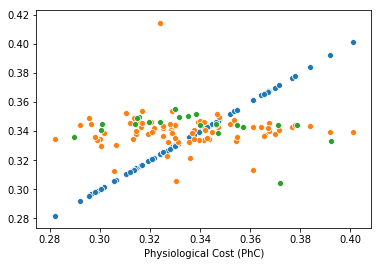

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_avg, y, test_size=0.20, random_state=42, shuffle=True)
train_set = MyDataset(train_data=X_train, train_target=y_train)

errors.update({"4-layer default error":test_model(model, train_set, X_test, y_test, batch_size, num_epochs)})

Как мы успели заметить, выявление новых признаков, а также вариация количества слоёв моделей даёт точность порядка 1е-2. Далее попробуем нормализовать данные.

## Нормализация данных
попробуем нормализовать входные данные и посмотреть, как это отразится на точночти

In [38]:
# x_maxes = np.argmax(X.values, axis=0)
# for i in range(X.shape[1]):
#     X.values[:,i] /= X.values[x_maxes[i], i]
for col in range(X.shape[1]):
    X.values[:, col] -= X.values[np.argmin(X.values[:, col]), col]
    X.values[:, col] /= X.values[np.argmax(X.values[:, col]), col]
y_min = y.values[np.argmin(y.values)]
y -= y_min
y_max = y.values[np.argmax(y.values)]
y /= y_max
print(y.mean(), y.std())
for i in range(X.shape[1]):
    print("X",i)
    print(X.values[:,i].mean(), X.values[:,i].std())

0.44544873944719426 0.21096736191494658
X 0
0.19195637367237225 0.1845901965760129
X 1
0.22354089797769086 0.19928094969895688
X 2
0.3856176181478605 0.15768761133772027
X 3
0.39717666823249553 0.20096861589333925


In [39]:
ard = ARDRegression()
ard.fit(X, y)

print(ard.coef_)

[ 0.00059873 -0.40570796  0.          0.0272053 ]


Выходит, что больших отличий между важностью признаков нет (в ненормализованном случае они вообще не отличаются)

Наиболее бесполезным оказался третий признак. в дальнейшем попробуем его исключить.

In [40]:
model = nn.Sequential(
    nn.BatchNorm1d(4),
    nn.Linear(4,32),
    nn.BatchNorm1d(32),
    nn.ReLU(),
#     nn.Dropout(0.1),
    nn.Linear(32,32),
    nn.BatchNorm1d(32),
    nn.ReLU(),
#     nn.Dropout(0.1),
    nn.Linear(32, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
#     nn.Dropout(0.1),
    nn.Linear(64,1)
)

CPU times: user 14.2 s, sys: 156 ms, total: 14.3 s
Wall time: 2.81 s
ошибка текущей модели: 1.968201832330199e-01


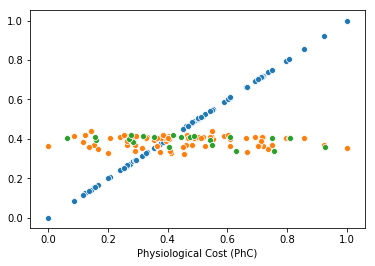

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)
train_set = MyDataset(train_data=X_train, train_target=y_train)
errors.update({"normalized error":test_model(model, train_set, X_test, y_test, batch_size, num_epochs)})

In [42]:
model = nn.Sequential(
    nn.BatchNorm1d(3),
    nn.Linear(3,32),
    nn.BatchNorm1d(32),
    nn.ReLU(),
#     nn.Dropout(0.1),
    nn.Linear(32,32),
    nn.BatchNorm1d(32),
    nn.ReLU(),
#     nn.Dropout(0.1),
    nn.Linear(32, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
#     nn.Dropout(0.1),
    nn.Linear(64,1)
)

In [43]:
X_3 = X.drop('TRIMP3', axis='columns')

CPU times: user 14.2 s, sys: 106 ms, total: 14.3 s
Wall time: 2.84 s
ошибка текущей модели: 1.866134086462969e-01


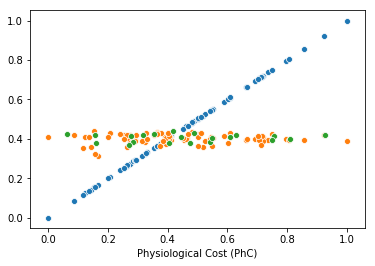

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_3, y, test_size=0.20, random_state=42, shuffle=True)
train_set = MyDataset(train_data=X_train, train_target=y_train)
errors.update({"normalized error":test_model(model, train_set, X_test, y_test, batch_size, num_epochs)})

Второй признак по бесполезности - первый

In [45]:
model = nn.Sequential(
    nn.BatchNorm1d(2),
    nn.Linear(2,32),
    nn.BatchNorm1d(32),
    nn.ReLU(),
#     nn.Dropout(0.1),
    nn.Linear(32,32),
    nn.BatchNorm1d(32),
    nn.ReLU(),
#     nn.Dropout(0.1),
    nn.Linear(32, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
#     nn.Dropout(0.1),
    nn.Linear(64,1)
)

In [46]:
X_2 = X.drop(['TRIMP3','TRIMP1'], axis='columns')

CPU times: user 14.2 s, sys: 111 ms, total: 14.3 s
Wall time: 2.77 s
ошибка текущей модели: 1.773836787436055e-01


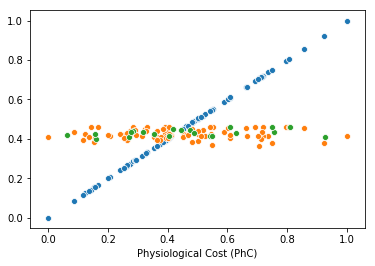

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_2, y, test_size=0.20, random_state=42, shuffle=True)
train_set = MyDataset(train_data=X_train, train_target=y_train)
errors.update({"normalized error":test_model(model, train_set, X_test, y_test, batch_size, num_epochs)})

С нормализацией результаты оказались не лучше, чем без неё. Значит, отбросим эту идею.

Восстановим исходный датасет.

In [48]:
X = edited_features.drop(['Physiological Cost (PhC)'], axis='columns')
y = edited_features['Physiological Cost (PhC)'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)

Далее попробуем изменять параметры в пределах стандартного отклонения, и целевой признак в соответствии с ними же.

In [49]:
coefs = pd.DataFrame(data=ard.coef_.reshape(1,4), columns=('TRIMP1','TRIMP2','TRIMP3','TRIMP4'))
# попытка домножать на коэффициенты ARD не помогла улучшить результат
X_new = []
y_new = []
for i in range(3):
    for col in X_train:
        X_train_c = X_train.copy()
        y_train_c = y_train.copy()
        std = X_train_c[col].std()
        X_chn = np.random.normal(loc=0, scale=std, size=X_train_c[col].shape) 
        y_chn = np.random.normal(loc=0, scale=y_train_c.values.std(), size=y_train_c.shape) * coefs.loc[0, col] 
        X_train_c[col] -= X_chn
        mask = np.sign(X_chn) == np.sign(y_chn)
        if col == 'TRIMP2':
            y_train_c[mask] += y_chn[mask]
        else:
            y_train_c[mask] -= y_chn[mask]
        mask = np.sign(X_chn) != np.sign(y_chn)
        if col == 'TRIMP2':
            y_train_c[mask] -= y_chn[mask]
        else:
            y_train_c[mask] += y_chn[mask]

        X_new.append(X_train_c)
        y_new.append(y_train_c)
X_new = np.vstack(X_new)
y_new = np.vstack(y_new).reshape(-1, 1).squeeze()
print(X_new.shape)
print(y_new.shape)

(984, 4)
(984,)


In [50]:
model = nn.Sequential(
    nn.BatchNorm1d(4),
    nn.Linear(4,32),
    nn.BatchNorm1d(32),
    nn.ReLU(),
#     nn.Dropout(0.1),
    nn.Linear(32,32),
    nn.BatchNorm1d(32),
    nn.ReLU(),
#     nn.Dropout(0.1),
    nn.Linear(32, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
#     nn.Dropout(0.1),
    nn.Linear(64,1)
)

Epoch [1/100], Step [10/40], Loss: 71.0992
Epoch [1/100], Step [20/40], Loss: 16.5201
Epoch [1/100], Step [30/40], Loss: 28.6642
Epoch [1/100], Step [40/40], Loss: 1.8998
Epoch [2/100], Step [10/40], Loss: 13.3420
Epoch [2/100], Step [20/40], Loss: 12.0429
Epoch [2/100], Step [30/40], Loss: 17.8324
Epoch [2/100], Step [40/40], Loss: 1.9484
Epoch [3/100], Step [10/40], Loss: 15.5679
Epoch [3/100], Step [20/40], Loss: 12.8349
Epoch [3/100], Step [30/40], Loss: 12.8598
Epoch [3/100], Step [40/40], Loss: 1.9985
Epoch [4/100], Step [10/40], Loss: 10.3065
Epoch [4/100], Step [20/40], Loss: 11.9314
Epoch [4/100], Step [30/40], Loss: 12.1689
Epoch [4/100], Step [40/40], Loss: 1.9300
Epoch [5/100], Step [10/40], Loss: 13.7990
Epoch [5/100], Step [20/40], Loss: 13.4665
Epoch [5/100], Step [30/40], Loss: 14.5787
Epoch [5/100], Step [40/40], Loss: 1.5935
Epoch [6/100], Step [10/40], Loss: 12.1528
Epoch [6/100], Step [20/40], Loss: 11.1217
Epoch [6/100], Step [30/40], Loss: 10.4543
Epoch [6/100], S

Epoch [49/100], Step [10/40], Loss: 8.8274
Epoch [49/100], Step [20/40], Loss: 7.7615
Epoch [49/100], Step [30/40], Loss: 8.7888
Epoch [49/100], Step [40/40], Loss: 1.1063
Epoch [50/100], Step [10/40], Loss: 8.6585
Epoch [50/100], Step [20/40], Loss: 9.0517
Epoch [50/100], Step [30/40], Loss: 7.7906
Epoch [50/100], Step [40/40], Loss: 1.1295
Epoch [51/100], Step [10/40], Loss: 7.3405
Epoch [51/100], Step [20/40], Loss: 10.1711
Epoch [51/100], Step [30/40], Loss: 8.8597
Epoch [51/100], Step [40/40], Loss: 2.1103
Epoch [52/100], Step [10/40], Loss: 8.3562
Epoch [52/100], Step [20/40], Loss: 11.9704
Epoch [52/100], Step [30/40], Loss: 9.8095
Epoch [52/100], Step [40/40], Loss: 0.9890
Epoch [53/100], Step [10/40], Loss: 9.4454
Epoch [53/100], Step [20/40], Loss: 8.8733
Epoch [53/100], Step [30/40], Loss: 8.7015
Epoch [53/100], Step [40/40], Loss: 1.0952
Epoch [54/100], Step [10/40], Loss: 7.1169
Epoch [54/100], Step [20/40], Loss: 7.4060
Epoch [54/100], Step [30/40], Loss: 9.5968
Epoch [54

Epoch [97/100], Step [10/40], Loss: 7.9661
Epoch [97/100], Step [20/40], Loss: 6.3463
Epoch [97/100], Step [30/40], Loss: 9.3852
Epoch [97/100], Step [40/40], Loss: 1.0459
Epoch [98/100], Step [10/40], Loss: 6.6307
Epoch [98/100], Step [20/40], Loss: 9.4869
Epoch [98/100], Step [30/40], Loss: 9.6037
Epoch [98/100], Step [40/40], Loss: 1.4727
Epoch [99/100], Step [10/40], Loss: 8.7879
Epoch [99/100], Step [20/40], Loss: 8.1700
Epoch [99/100], Step [30/40], Loss: 10.6551
Epoch [99/100], Step [40/40], Loss: 1.0380
Epoch [100/100], Step [10/40], Loss: 8.3435
Epoch [100/100], Step [20/40], Loss: 9.0585
Epoch [100/100], Step [30/40], Loss: 9.7495
Epoch [100/100], Step [40/40], Loss: 1.0284
CPU times: user 1min 38s, sys: 772 ms, total: 1min 39s
Wall time: 20.9 s
ошибка текущей модели: 2.038148893817583e-02


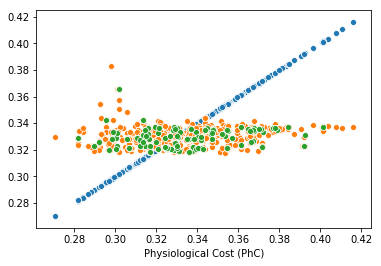

In [51]:
batch_size = 20
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.20, random_state=42, shuffle=True)
train_set = MyDataset(train_data=X_train, train_target=y_train)

errors.update({"modified-extended error":test_model(model, train_set, X, y, batch_size, num_epochs)})

Я не смог добиться точности выше, чем 1е-2.

In [52]:
# def test_model(model, train_set, X_test, y_test, batch_size=20, num_epochs=10):
#     model.train()
#     %time train(model, train_set, batch_size, epochs=num_epochs)

#     model.eval()
#     y_pred = model.forward(torch.Tensor(np.asarray(X_test, dtype=np.float64))).detach().numpy()

#     test_accuracy(y_test, y_pred)

In [53]:
X_rel = np.zeros((X.shape[0] - 2, 3, X.shape[1]), dtype=np.float64)
y_rel = y[2::]
for i in range(2, X.shape[0]):
    for j in range(3):
        X_rel[i - 2, j] = X.values[i - 2 + j]

In [54]:
print(X_rel.shape)

(101, 3, 4)


In [55]:
class UnRNN(nn.Module):
    def forward(self, out):
#         return out[0][:, -1, : ]
        return out[1][-1, -1, : ]
#         return torch.cat((out[0],out[1]), 2)

In [56]:
batch_size = 20
model = nn.Sequential(
    nn.RNN(input_size=4, hidden_size=16, num_layers=2, dropout=0, batch_first=True),
    UnRNN(),
    nn.ReLU(),
    nn.Linear(16,1)
)

CPU times: user 5.41 s, sys: 43.8 ms, total: 5.45 s
Wall time: 1.95 s
ошибка текущей модели: 2.021634989476812e-02


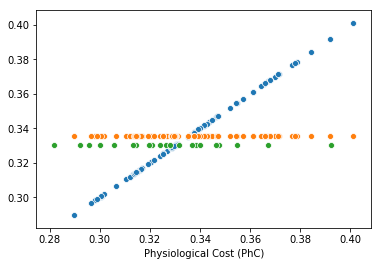

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_rel, y_rel, test_size=0.20, random_state=42, shuffle=True)
train_set = MyDataset(train_data=X_train, train_target=y_train)

errors.update({"rnn error":test_model(model, train_set, X_test, y_test, batch_size, num_epochs)})

От запоминания последних трёх дней лучше не стало.

In [58]:
skipped_days = main_features.copy()
skipped_days['skipped'] = pd.Series(data=np.zeros(skipped_days.shape[0]), index=skipped_days.index, dtype=np.int32)
for day in range(12, skipped_days.shape[0]):
    if np.isnan(skipped_days['Physiological Cost (PhC)'][day - 1]):
        skipped_days['skipped'][day] = skipped_days['skipped'][day - 1] + 1
skipped_days.head(10)

/home/vyacheslav/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,Physiological Cost (PhC),TRIMP1,TRIMP2,TRIMP3,TRIMP4,skipped
11,0.372097,802.127,138.638,1.23169,0,0
12,0.353656,1450.13,100.318,1341.57,579.98,0
13,0.354685,732.626,70.6103,2440.17,1695.58,0
14,0.330189,809.691,13.2364,1778.61,880.455,0
15,0.371243,769.12,26.4721,1773.54,887.856,0
16,NaN,1366.48,494.083,1328.01,585.427,0
17,0.319281,738.895,1.30417,2444.16,1676.64,1
18,0.347529,670.607,10.3701,1779.52,877.502,0
19,0.367796,722.044,51.7193,1776.15,889.079,0
20,NaN,NaN,NaN,NaN,NaN,0


In [59]:
model = nn.Sequential(
    nn.BatchNorm1d(5),
    nn.Linear(5,32),
    nn.BatchNorm1d(32),
    nn.ReLU(),
    nn.Linear(32,32),
    nn.BatchNorm1d(32),
    nn.ReLU(),
    nn.Linear(32, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Linear(64,1)
)

In [60]:
skipped_days.dropna(axis=0, inplace=True)
X_skip = skipped_days.drop(['Physiological Cost (PhC)'], axis='columns')
y_skip = skipped_days['Physiological Cost (PhC)'].copy()

CPU times: user 11.8 s, sys: 110 ms, total: 11.9 s
Wall time: 2.32 s
ошибка текущей модели: 2.613377906444731e-02


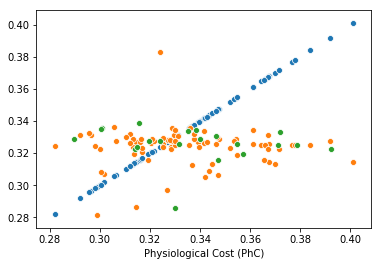

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X_skip, y_skip, test_size=0.20, random_state=42, shuffle=True)
train_set = MyDataset(train_data=X_train, train_target=y_train)

errors.update({"skipped error":test_model(model, train_set, X_test, y_test, batch_size, num_epochs)})

In [62]:
# я устал
del model
del train_set
del X
del X_2
del X_3
del X_avg
del X_chn
del X_new
del X_prod
del X_rel
del X_skip
del X_sum
del X_train
del X_train_c
del y
del y_chn
del y_new
del y_rel
del y_skip
del y_train
del y_train_c

Далее попробуем применить деревья

In [4]:
X = edited_features.drop(['Physiological Cost (PhC)'], axis='columns')
y = edited_features['Physiological Cost (PhC)'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [5]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor(criterion='mae', random_state=42)
tree.fit(X=X_train, y=y_train)
y_pred = tree.predict(X_test)
sns.scatterplot(y_train, tree.predict(X_train)) 
sns.scatterplot(y_test, y_pred)
errors.update({"tree error":test_accuracy(y_test, y_pred)})

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [65]:
tree.score(X_test, y_test)

0.22597719395158777

In [66]:
X_skip = skipped_days.drop(['Physiological Cost (PhC)'], axis='columns')
y_skip = skipped_days['Physiological Cost (PhC)'].copy()
X_train, X_test, y_train, y_test = train_test_split(X_skip, y_skip, test_size=0.20, random_state=42, shuffle=True)

ошибка текущей модели: 1.932309366666666e-02


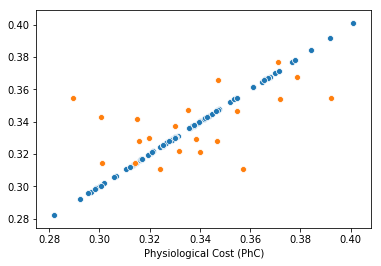

In [67]:
tree = DecisionTreeRegressor(criterion='mae', random_state=42)
tree.fit(X=X_train, y=y_train)
y_pred = tree.predict(X_test)
sns.scatterplot(y_train, tree.predict(X_train)) 
sns.scatterplot(y_test, y_pred)
errors.update({"tree skipped error":test_accuracy(y_test, y_pred)})

In [68]:
for key, value in errors.items():
    print(key, value)

forecast error 0.05943365069409665
default(4) test error 0.02745405015195138
sum(6) error 0.02665566685203261
product(6) error 0.022615927230886547
average(6) error 0.021477257526579353
sum(2) error 0.02301563880713108
product(2) error 0.022006181748506812
average_1(2) error 0.022047012649354474
average_2(2) error 0.023107395800723116
average_3(2) error 0.02193943194216773
average(10) error 0.019844232151476175
4-layer default error 0.02744499906540789
normalized error 0.17738367874360547
modified-extended error 0.020381488938175832
rnn error 0.020216349894768122
skipped error 0.026133779064447308
tree error 0.01832631619047619
tree skipped error 0.019323093666666662
